author: leezeeyee   
date: 2021/4/12  
link: [github](https://github.com/easilylazy/pattern-recognition) 

In [1]:
import numpy as np
import torch

In [4]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

## 3分类问题
1，现有如下9个样本，假设样本（3，0.4）、（1，1）和（3，3）属于第一类，      
样本（2，0.5）、（3，1）和（1，3）属于第二类，    
样本（1，2）、（2，2）和（3，2）属于第三类，     
请自行设计神经网络实现上述样本的分类，希望能通过设计不同的隐含层数、每层的节点数、不同的学习率、不同的激活函数等对实验结果进行讨论。

## 过程中的问题与思考

1. 学习率很低，不收敛    
不知是否是算法有问题，更换数据后有所改善
因此需要调整网络结构
2. 增加网络隐藏层的节点数，收敛速度增加
3. 增加学习率，SGD的收敛速度有所提升

其实对于这部分的训练可视为过拟合的过程，没有测试集的验证

### 数据

In [583]:
# D=np.asarray([[-3,0.4],[-1,1],[-3,3],[2,-0.5],[3,-1],[1,-3],[1,2],[2,2],[3,2]])
D=np.asarray([[3,0.4],[1,1],[3,3],[2,0.5],[3,1],[1,3],[1,2],[2,2],[3,2]])
# Y=np.array([[1,0,0],[1,0,0],[1,0,0],[0,1,0],[0,1,0],[0,1,0],[0,0,1],[0,0,1],[0,0,1]])
Y=np.array([0,0,0,1,1,1,2,2,2],dtype=np.int64)

In [584]:
D = D.astype(np.float32)
D_np = torch.from_numpy(D)
# D_np
Y_np=torch.tensor(Y)
# Y_np

In [585]:
train_data=[]
for i in range(len(D)):
    train_data.append([D_np[i],Y_np[i]])

In [586]:
batch_size = 3

# Create data loaders.
train_dataloader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X in train_dataloader:
    # print("Shape of X [N, C, H, W]: ", X.shape)
    print(X)
    # print("Shape of y: ", y.shape, y.dtype)
    break

[tensor([[3.0000, 0.4000],
        [1.0000, 2.0000],
        [2.0000, 2.0000]]), tensor([0, 2, 2])]


In [588]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([3, 2])
Labels batch shape: torch.Size([3])


In [639]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.ReLU(),
            nn.Linear(2, 8),
            nn.ReLU(),
            # nn.Linear(8, 3),
            nn.Linear(8, 5),
            nn.ReLU(),
            nn.Linear(5, 3),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



Using cpu device


In [614]:
for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        print(X)
        print(y)

tensor([[3., 1.],
        [3., 3.],
        [1., 3.]])
tensor([1, 0, 1])
tensor([[3., 2.],
        [2., 2.],
        [1., 2.]])
tensor([2, 2, 2])
tensor([[2.0000, 0.5000],
        [3.0000, 0.4000],
        [1.0000, 1.0000]])
tensor([1, 0, 0])


In [615]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        # y=torch.tensor(y,dtype=torch.long)
        # print(pred,y)
        # print('sf')
        # print(pred[0][y[0]])
        loss = loss_fn(pred, y)
        # loss=(pred-y)**2
        # print(pred.argmax(1)==y)

        # print(loss)
        # print(loss.grad_fn)
        # Backpropagation
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        # if batch % 8 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [616]:
def test(dataloader, model, epoch):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # print(pred)
            # print(pred.argmax(1))
            # print(y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    # if epoch%10==0:
    #     print(f"Epoch {t+1}\n-------------------------------")
    #     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss,correct

In [617]:
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

In [618]:
epochs = 10000
# fig=plt.figure()
maxCorrect=0
for t in range(epochs):
    
    train(train_dataloader, model, loss_fn, optimizer)
    loss,correct=test(train_dataloader, model,t)
    if correct>maxCorrect:
        print(loss)
        print(correct)
        maxCorrect=correct
        if abs(maxCorrect-1)<1e-6:
            break
    # plt.plot(t,loss,'o')
print("Done!")

0.3714017868041992
0.4444444444444444
0.35349465741051567
0.5555555555555556
0.31484214464823407
0.6666666666666666
0.12070223026805454
0.7777777777777778
0.11125756634606256
0.8888888888888888
Done!


0.37485557794570923
0.3333333333333333
0.36240727371639675
0.4444444444444444
0.29278771082560223
0.6666666666666666
0.1919081707795461
0.7777777777777778
0.16766738229327732
0.8888888888888888
0.13583440085252127
1.0


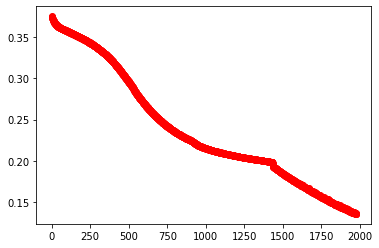

In [642]:
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
epochs = 10000
fig=plt.figure()
maxCorrect=0
for t in range(epochs):
    
    train(train_dataloader, model, loss_fn, optimizer)
    loss,correct=test(train_dataloader, model,t)
    if correct>maxCorrect:
        print(loss)
        print(correct)
        maxCorrect=correct
        if abs(maxCorrect-1)<1e-6:
            break
    plt.plot(t,loss,'o',color='r')

In [643]:
print(t)

1976


In [637]:
print(loss)
print(maxCorrect)

0.3937332166565789
0.3333333333333333


In [610]:
print(model.parameters)

<bound method Module.parameters of NeuralNetwork(
  (flatten): Flatten()
  (linear_relu_stack): Sequential(
    (0): ReLU()
    (1): Linear(in_features=2, out_features=8, bias=True)
    (2): ReLU()
    (3): Linear(in_features=8, out_features=3, bias=True)
  )
)>


In [611]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.6900, -0.3966],
        [ 0.5879, -1.3576],
        [ 0.7148, -1.4066],
        [ 0.5789,  0.5141],
        [-0.1868, -0.5629],
        [-0.0795,  0.5728],
        [ 0.3393,  0.4212],
        [ 0.7148, -1.5160]], requires_grad=True)
Parameter containing:
tensor([ 0.5031,  0.9520,  0.6696,  0.0760,  0.2995,  0.0080,  0.4870, -0.6338],
       requires_grad=True)
Parameter containing:
tensor([[ 0.0374,  0.1288, -0.1184,  0.0638, -0.2069,  0.0564, -0.0886,  1.6692],
        [-0.6103,  0.7330,  0.7696, -0.2007, -0.3239,  0.2409,  0.1085, -1.6642],
        [-0.0071, -0.6054, -0.9643,  0.2022,  0.3015,  0.0458, -0.1945, -0.5157]],
       requires_grad=True)
Parameter containing:
tensor([-0.1397,  0.1707,  0.3308], requires_grad=True)


In [ ]:
for param in model.parameters():
    param.reset
    print(param)

## utils

In [4]:
def addSingleBias(X):
    N=X.shape[0]
    X=np.reshape(X,[N,1])
    bias_vector=np.ones([1,1])
    return np.row_stack((bias_vector,X))
def addBias(X):
    '''
    为维数为N,d的向量X添加偏置向量
    Args:
        X(numpy.ndarray):shape为[N,d]
    Returns:
        numpy.ndarray:shape为[N,d+1]，且第一列列向量全为1
    '''
    
    try:
        N=X.shape[0]
        d=X.shape[1]
        if d == 1:
            return addSingleBias(X)
        bias_vector=np.ones([N,1])
        return np.column_stack((bias_vector,X))
        
    except:
        return addSingleBias(X)
    

In [ ]:
def Relu(X):
    '''
    return max(0,x)
    '''
    try:
        X[X<0]=0
        return X
    except:
        X=np.asarray(X)
        X[X<0]=0
        return X

In [407]:
entroy=nn.CrossEntropyLoss()
input=torch.Tensor([[-0.7715, -0.8205,-0.2562]])
target = torch.tensor([0])
output = entroy(input, target)
print(output)
print(output.grad_fn)


tensor(1.3447)
None
